In [51]:
from pydemic.diseases import covid19
import sklearn
import statsmodels.api as sm
import statsmodels.tsa.api as ts
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import prophet
from pathlib import Path
import datetime
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.regression.rolling import RollingOLS
from sklearn.neighbors import LocalOutlierFactor
from mundi.plugins.epidemic.covid19 import epidemic_curve
import mundi

from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [52]:
class EpiProphet:
    region = None
    
    @classmethod
    def from_region(cls, region, **kwargs):
        """
        Initialize epidemic curve from mundi region.
        """
        region = mundi.region(region)
        curves = epidemic_curve(region).diff()
        new = cls(curves, **kwargs)
        new.region = region
        return new
    
    def __init__(self, data, *, mode='logr', remove_outliers='local', deaths=False, **kwargs):
        self.data = data.copy()
        self.mode = mode
        self.deaths = deaths
        self.remove_outliers = remove_outliers
        
        kwargs.setdefault('seasonality_mode', 'additive')
        kwargs.setdefault('changepoint_range', 1.0 - 28 / len(self.data))
        
        self.model = Prophet(
            daily_seasonality=False,
            yearly_seasonality=False,
            **kwargs,
        )
        self.model.fit(self._training_data())
        
    def _training_data(self):
        # Convert data
        df = self.data['deaths' if self.deaths else 'cases']
        df = df[df != 0]
        if self.mode == 'log':
            df = np.log(df)
        elif self.mode in ('log-return', 'logr'):
            df = np.log(df).diff()
            df.iloc[0] == 0.0
        elif self.mode == ('return', 'ret'):
            df.iloc[1:] /= df.values[:-1]
            df.iloc[0] = 1.0
            
        # Remove outliers
        if self.remove_outliers == 'local':
            df = df.dropna()
            m = LocalOutlierFactor(21)
            outliers = m.fit_predict(df.values[:, None])
            df = df[outliers == 1]
            
        return pd.DataFrame({'y': df.values, 'ds': df.index})
    
    def _forecast(self, periods=60):
        """
        Prepare raw forecast for the next period days.
        """
        future = self.model.make_future_dataframe(periods=periods)
        return self.model.predict(future)
    
    def fatality_ratio(self, last=False):
        """
        Estimate fatality ratio from data
        """
        rm = RollingOLS(m.data['deaths'], m.data['cases'], 28)
        res = rm.fit()
        fatality = res.params
        if last:
            return fatality.values[-1]
        return fatality
    
    def forecast(self, periods=60):
        """
        Project epicurve of new daily cases or deaths (depending on initialization data).
        
        Args:
            periods:
                Periods in the future to predict.
            acc:
                If True, accumulate return values.
        """
        forecast = self._forecast(periods=periods)
        df = pd.DataFrame({
            'deaths_hat': np.exp(forecast['yhat']),
            'deaths_lower': np.exp(forecast['yhat_lower']),
            'deaths_upper': np.exp(forecast['yhat_upper']),
            'date': forecast['ds']
        }).set_index('date')

        df['deaths'] = self.data['deaths']
        deaths = df['deaths'].copy()
        df['deaths'] = deaths.fillna(df['deaths_hat'])

        df['deaths_acc'] = np.add.accumulate(df['deaths'])
        df['deaths_acc_lower'] = np.add.accumulate(deaths.fillna(df['deaths_lower']))
        df['deaths_acc_upper'] = np.add.accumulate(deaths.fillna(df['deaths_upper']))

        # Include cases
        CFR = self.fatality_ratio(last=True)
        df['cases'] = self.data['cases']
        cases = df['cases'].copy()
        df['cases'] = cases.fillna(df['deaths_hat'] / CFR)

        df['cases_acc'] = np.add.accumulate(df['cases'])
        df['cases_acc_lower'] = np.add.accumulate(cases.fillna(df['deaths_lower'] / CFR))
        df['cases_acc_upper'] = np.add.accumulate(cases.fillna(df['deaths_upper'] / CFR))

        # Simple estimate of ICU occupation
        deaths_trend = np.exp(forecast['trend'])
        deaths_trend.index = forecast['ds']
        params = covid19.params(region=self.region)
        df['icu'] = deaths_trend / params.icu_fatality_ratio * params.icu_period

        # Simple estimate of ICU occupation
        hospitalization_bias = 0.33 # self.hospitalization_bias
        params = covid19.params(region=self.region)
        df['severe'] = deaths_trend / params.icu_fatality_ratio / params.prob_aggravate_to_icu * params.severe_period * hospitalization_bias
        df['K'] = forecast[['trend', 'ds']].set_index('ds').diff()
        
        return df
        
    def plot_pdf(self, nbins=50, **kwargs):
        data = self._training_data()['y'].values
        bins = plt.hist(data, nbins, **kwargs)
        y0, y1 = plt.ylim()
        
        mu = data.mean()
        plt.plot([mu, mu], [y0, y1], 'k--', lw=2)
        plt.ylim(y0, y1)
        plt.ylim(y0, y1)
        
        std = data.std()
        plt.plot([mu - std, mu - std], [y0, y1], 'k--', lw=1)
        plt.plot([mu + std, mu + std], [y0, y1], 'k--', lw=1)
        
        plt.fill_betweenx([y0, y1], mu - std, mu + std, color='0.5', alpha=0.5)
        
        return bins
        
    def plot_acf(self, **kwargs):
        kwargs.update(nlags=120, fft=True)
        plt.plot(ts.acf(data, **kwargs))
        plt.grid(True)
        
    def plot_forecast(self, periods=60, change_points=True):
        forecast = self._forecast(periods)
        fig = self.model.plot(forecast)
        if change_points:
            add_changepoints_to_plot(fig.gca(), self.model, forecast)
        return fig
    
    def plot_components(self, periods=60, change_points=False):
        forecast = self._forecast(periods)
        fig = self.model.plot_components(forecast)
        if change_points:
            add_changepoints_to_plot(fig.get_axes()[-2], self.model, forecast)
        return fig
    

In [61]:
def plot_data(path, data: pd.DataFrame, region, ext='png', future=60, past=120, show=False):
    data = data.iloc[-(past + future):].copy().reset_index()
    data.index -= past
    today = datetime.datetime.now().date()
    
    def common(name):
        plt.legend()
        plt.tight_layout()
        _y0, y1 = plt.ylim()
        plt.plot([0, 0], [0, y1], 'k--', lw=2)
        plt.ylim(0, y1)
        plt.xlim(data.index[0], data.index[-1])
        plt.grid(True)
        if show:
            plt.show() 
        plt.savefig(path / name)
        plt.clf()

    deaths = data['deaths']
    deaths.rolling(14, 1, center=True, win_type='triang').mean().plot(label='média móvel')
    deaths.plot(label='mortes/dia')
    plt.xlabel(f'dias (a partir de {today})')
    plt.ylabel('mortes')
    plt.title(f'Projeção de óbitos por Covid-19 ({region.name})')
    common(f'{region.id}-obitos.{ext}')

    cases = data['cases']
    cases.rolling(14, 1, center=True, win_type='triang').mean().plot(label='média móvel')
    cases.plot(label='casos/dia')
    plt.xlabel(f'dias (a partir de {today})')
    plt.ylabel('casos')
    plt.title(f'Projeção de casos por Covid-19 ({region.name})')
    common(f'{region.id}-casos.{ext}')

    icu = data['icu']
    icu.rolling(14, 1, center=True, win_type='triang').mean().plot(label='média móvel')
    icu.plot(label='leitos UTI')
    plt.xlabel(f'dias (a partir de {today})')
    plt.ylabel('leitos ocupados')
    plt.title(f'Projeção de pressão hospitalar por Covid-19 ({region.name})')
    common(f'{region.id}-criticos.{ext}')


In [65]:
br = []
for region in [*mundi.regions(type='state', country='BR'), mundi.region('BR')]:
    print(region)
    m = EpiProphet.from_region(
        region, 
        deaths=True, 
        mode='log', 
        remove_outliers='local',
        changepoint_prior_scale=0.2,
        seasonality_prior_scale=0.05,
    )
    res = m.forecast()
    res.to_csv(f'{m.region.id}.csv')
    
    plot_data(Path.cwd(), res, region)
    br.append(res.reset_index())

Mundi Region
id       : BR-MS
name     : Mato Grosso do Sul
type     : state
subtype  : None
Mundi Region
id       : BR-RO
name     : Rondônia
type     : state
subtype  : None
Mundi Region
id       : BR-ES
name     : Espírito Santo
type     : state
subtype  : None
Mundi Region
id       : BR-SP
name     : São Paulo
type     : state
subtype  : None
Mundi Region
id       : BR-RR
name     : Roraima
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-MA
name     : Maranhão
type     : state
subtype  : None
Mundi Region
id       : BR-AM
name     : Amazonas
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-AL
name     : Alagoas
type     : state
subtype  : None
Mundi Region
id       : BR-AC
name     : Acre
type     : state
subtype  : None
Mundi Region
id       : BR-AP
name     : Amapá
type     : state
subtype  : None
Mundi Region
id       : BR-BA
name     : Bahia
type     : state
subtype  : None
Mundi Region
id       : BR-PA
name     : Pará
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-TO
name     : Tocantins
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/statsmodels/regression/rolling.py:265: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood


Mundi Region
id       : BR-GO
name     : Goiás
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-CE
name     : Ceará
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-PB
name     : Paraíba
type     : state
subtype  : None
Mundi Region
id       : BR-RJ
name     : Rio de Janeiro
type     : state
subtype  : None
Mundi Region
id       : BR-RS
name     : Rio Grande do Sul
type     : state
subtype  : None
Mundi Region
id       : BR-SE
name     : Sergipe
type     : state
subtype  : None
Mundi Region
id       : BR-MT
name     : Mato Grosso
type     : state
subtype  : None
Mundi Region
id       : BR-RN
name     : Rio Grande do Norte
type     : state
subtype  : None
Mundi Region
id       : BR-MG
name     : Minas Gerais
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-PE
name     : Pernambuco
type     : state
subtype  : None
Mundi Region
id       : BR-PI
name     : Piauí
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-PR
name     : Paraná
type     : state
subtype  : None


/usr/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mundi Region
id       : BR-DF
name     : Distrito Federal
type     : state
subtype  : federal district
Mundi Region
id       : BR-SC
name     : Santa Catarina
type     : state
subtype  : None
Mundi Region
id       : BR
name     : Brazil
type     : country
subtype  : None


<Figure size 1200x800 with 0 Axes>

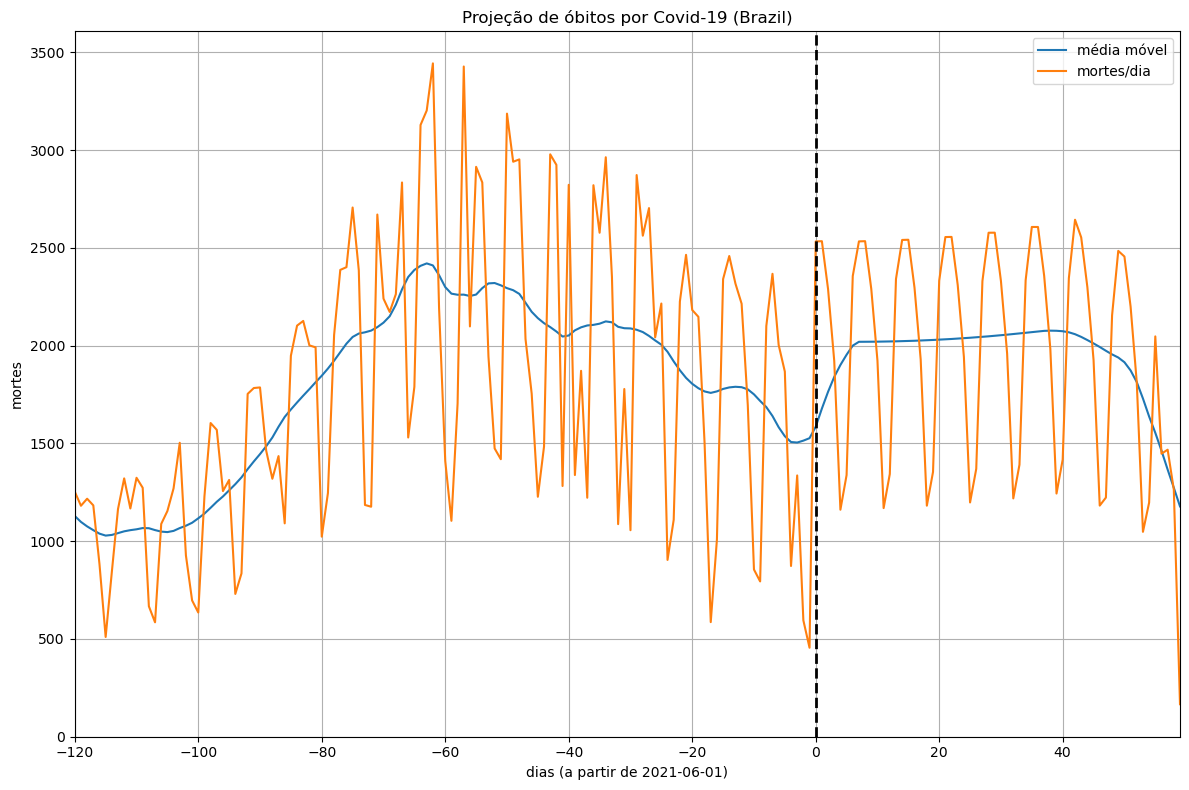

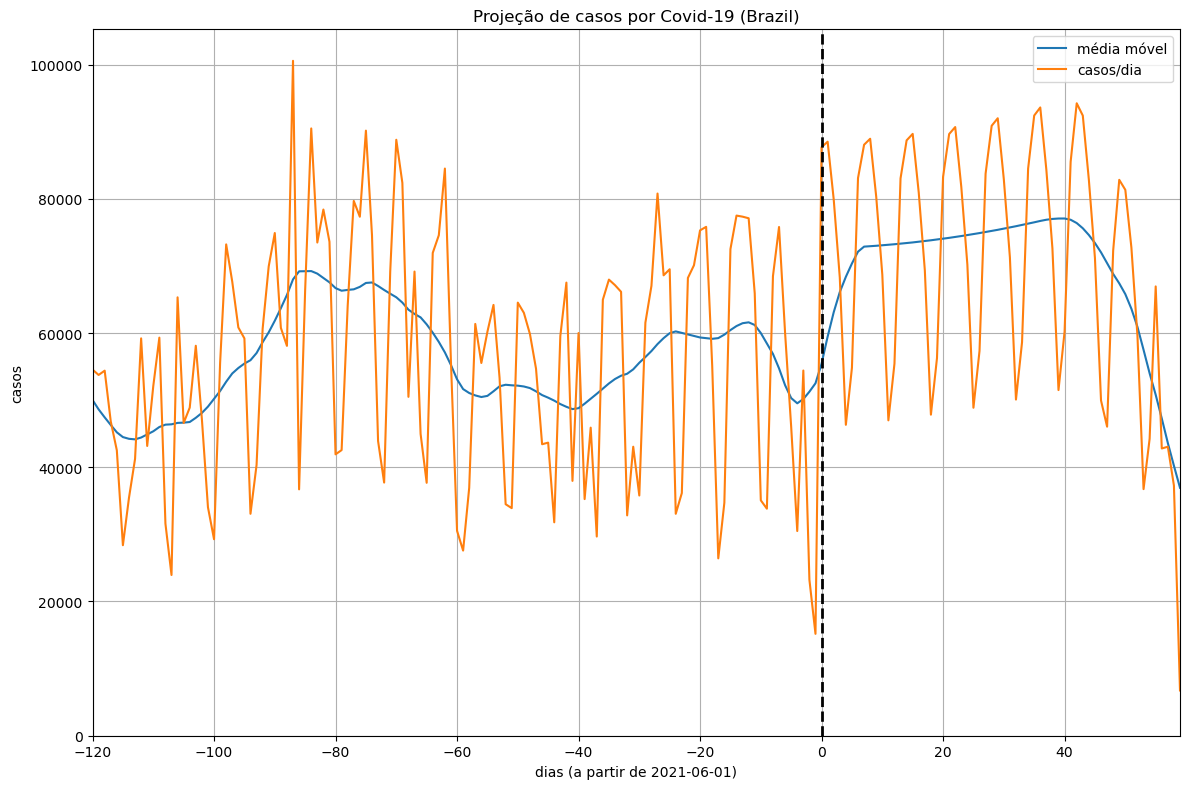

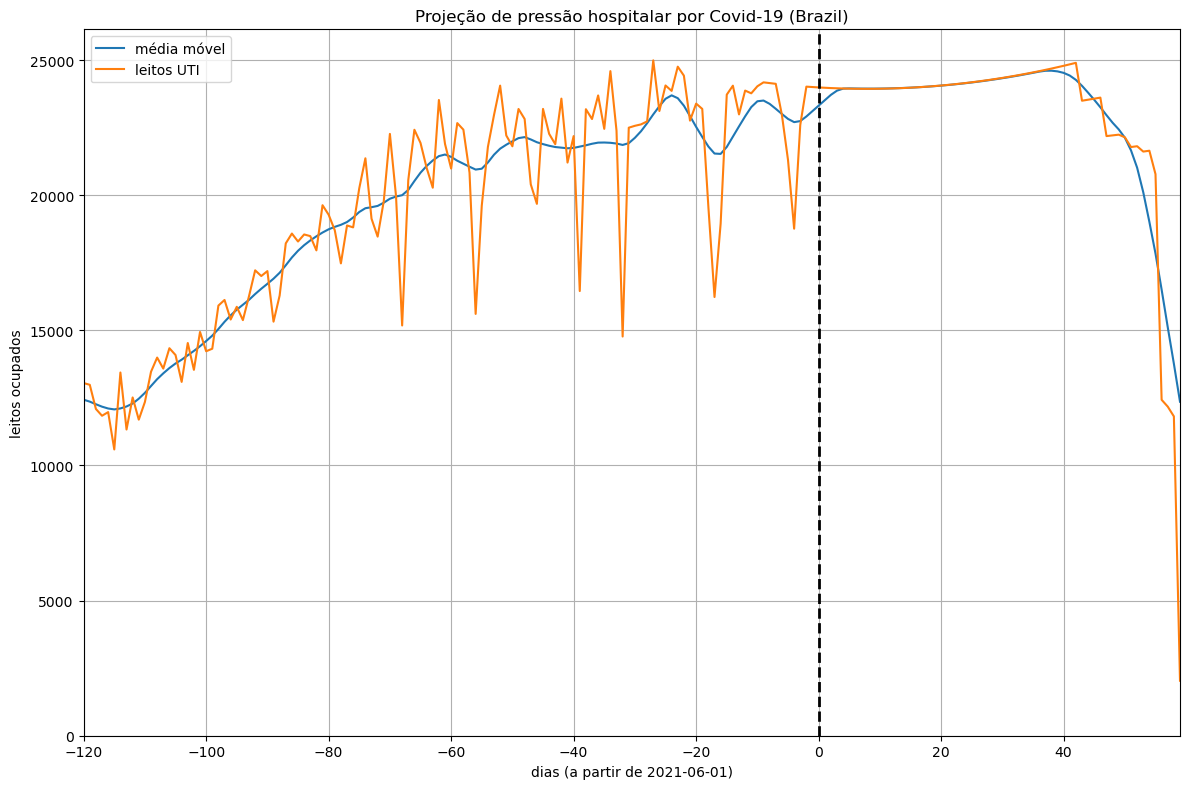

<Figure size 1200x800 with 0 Axes>

In [62]:
df = pd.concat([st.iloc[-180:] for st in br]).groupby('date').sum()
plot_data(Path.cwd(), df, mundi.region('BR'), show=True)
df.to_csv('BR.csv')

In [64]:
[*map(len, br)]

[376,
 401,
 442,
 463,
 281,
 417,
 474,
 395,
 418,
 415,
 459,
 435,
 418,
 433,
 448,
 418,
 467,
 448,
 384,
 348,
 353,
 379,
 453,
 448,
 482,
 441,
 467]